In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.constants import golden
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(10.0, 10.0/golden))

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

# PULIZIA DATI
distance_cond = tragitti[distance_param] != 0
moovit_cond = tragitti['Public'] > 12
public_cond = tragitti['Public'] != 0
bike_cond = tragitti['Bike'] != 0
foot_cond = tragitti['Foot'] != 0
car_cond = tragitti['Car'] != 0
car2go_cond = tragitti['Car2Go'] != 0
enjoy_cond = tragitti['Enjoy'] != 0
coherence_cond = (tragitti['Car'] <= tragitti['Car2Go']) & (tragitti['Car'] <= tragitti['Enjoy'])
cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond

In [2]:
tragitti = tragitti[car_cond]
tragitti.head()

,Lat,Lon,Elat,Elon,ADistance,FDistance,Year,Month,Day,Hour,...,Public,Public2,Bike,Foot,Car,Car2Go,Enjoy,Car2GoFreeCars,EnjoyFreeCars,CDistance
64800,45.474498,9.180897,45.496506,9.224699,4.200852,5.1607,2020,5,4,0,...,33,0,25,69,12,16,17,936,645,6.1379
64801,45.443876,9.184415,45.484429,9.187623,4.516006,5.1087,2020,5,4,0,...,28,0,27,68,14,20,20,936,645,7.2949
64802,45.450619,9.182201,45.502500,9.181618,5.768806,6.3926,2020,5,4,0,...,37,0,36,86,18,22,19,936,645,8.8463
64803,45.504757,9.188484,45.468675,9.156064,4.741568,5.7370,2020,5,4,0,...,48,0,26,77,14,18,23,936,645,6.9053
64804,45.480547,9.195806,45.501923,9.203171,2.445134,2.9488,2020,5,4,0,...,35,0,16,39,9,10,21,936,640,3.4690


In [3]:
center_point = (45.464216, 9.191949)
point_onepointfive_km_far = (45.463878, 9.208735)
center_point_radius = math.sqrt(
    (point_onepointfive_km_far[0] - center_point[0])**2. +
    (point_onepointfive_km_far[1] - center_point[1])**2.) # 1.5 km di raggio dal duomo di milano

def pass_through_center(tratta):
    start_point = tratta[0]
    end_point = tratta[1]
    medium_point = (float(start_point[0] + end_point[0]) / 2., float(start_point[1] + end_point[1]) / 2.)
    
    if ((medium_point[0] - center_point[0])**2. + (medium_point[1] - center_point[1])**2. <= center_point_radius**2.):
        return True
    else:
        return False    

In [4]:
propertydf = tragitti.apply(lambda p: pass_through_center(((p['Lat'], p['Lon']), (p['Elat'], p['Elon']))), axis=1)

In [5]:
len(tragitti)

63210

In [6]:
len(tragitti[propertydf == True])

30590

In [7]:
len(tragitti[propertydf == False])

32620

In [8]:
# Velocita' media durante il giorno
def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore
    
def vmedia_week(df, mezzo):
    short_paths = df[distance_param].between(2.0, 6.0)
    long_paths = df[distance_param].between(6.0, 10.0)
    
    lst = [
        vmedia_giorno(df[short_paths & (propertydf == True)], mezzo),
        vmedia_giorno(df[long_paths & (propertydf == True)], mezzo),
        vmedia_giorno(df[short_paths & (propertydf == False)], mezzo),
        vmedia_giorno(df[long_paths & (propertydf == False)], mezzo)]
    
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=[
        '[2, 6) km centro', '[6, 10) km centro',
        '[2, 6) km fuori', '[6, 10) km fuori']).round(2)

wcolors = ['dodgerblue', 'royalblue', 'lightcoral', 'tomato']

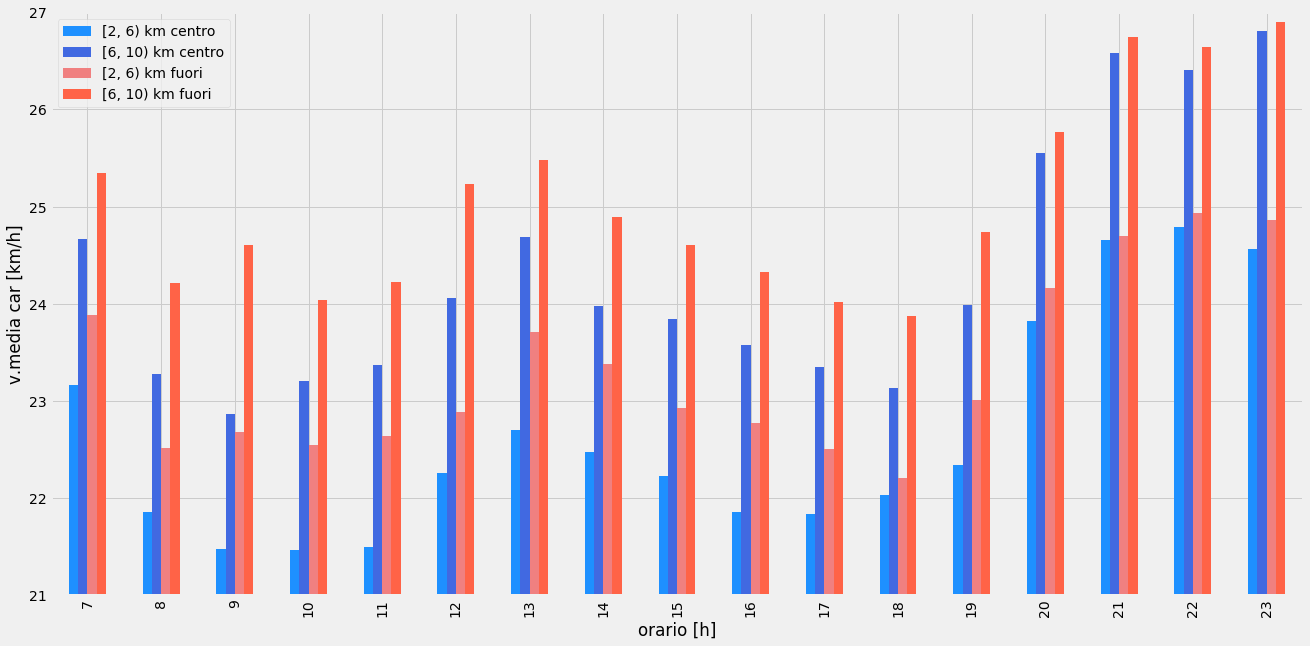

In [9]:
plt.rc('figure', figsize=((20, 10)))
vmedia_week(tragitti, 'Car').plot.bar(color=wcolors)
plt.ylim(21, 27)
plt.xlabel('orario [h]')
plt.ylabel('v.media car [km/h]')
plt.show()